**Please note this jupyter notebook is in Julia, if you are looking for a python version of Gillespie Algorithm, please click the following link of epidemic outbreak project.**

https://github.com/je-suis-tm/graph-theory/blob/master/Epidemic%20Outbreak%20project/gillespie%20algorithm.ipynb

**Tilman Model is based upon Levins Model, please click the following link of habitat occupancy.**

https://github.com/je-suis-tm/graph-theory/blob/master/habitat%20occupancy.ipynb

&nbsp;
# Habitat Competition
&nbsp;

Levins model has exceptional explanatory power for habitat fragmentation. American ecologist David Tilman expanded the model even further to a more general case for multiple species. In Tilman model, the ordinary differential equations construct a Darwanian system. Each species exhibits different scales of aggression. The stronger species can out-compete and displace weaker species. In this example, the model will illustrate the vis-à-vis among native species and invasive species. With the blessing of the spatial structure, some of the native species in remote area may actually be able to survive. This phenomenon proves why new species are often found in the tropical forests where trace of human rarely occurs. In the later chapter of this script, we will introduce Schelling’s model from sociology to study how the segregation is formed when multiple groups are presented in the system. Schelling’s model shows some unique traits when implemented on a random geometric graph.

&nbsp;
### Tilman Model
&nbsp;

`dPi/dt=ciPi(1-∑Pj)-eiPi-∑cjPiPj`

where

`Pi` denotes the fraction of occupied patchy habitat for species `i`, 1 is the total sum of available patchy habitats

`ci` denotes colonization rate for species `i`, which is proportional to number of occupied patchy habitats

`ei` denotes extinction rate of occupied patchy habitat for species `i`

&nbsp;
### Agent-based Modelling
&nbsp;

`dPi/dt=∑(αm-δm)Pi,m+∑Aijϵij,m(Pj,m-Pi,m)`

where

`Pi` denotes the population of habitat `i`

`Pi,m` denotes the population of species `m` in habitat `i`

`αm` denotes crude birth rate for species `m`, assume this species can carry sperm and switch gender, as long as it is alive it can reproduce, lol

`δm` denotes crude death rate for species `m`, it is density-independent in this case

`Aij` denotes adjacency matrix of a random geometric graph

`ϵij,m` denotes emigration rate of species `m` from habitat `i` to habitat `j`, to make our lives easier, emigration rate is identical within species in this case, `ϵij,m=ϵ, ∀i,j,m`

&nbsp;

In [1]:
using Plots
using Random

In [2]:
cd("h:/")

In [3]:
#create random geometric graph
#return the adjacency matrix
#the raison d'être of random geometric graph is
#its similarity with real geographic features
#where places are more likely to be connected within certain radius
function create_rgg(num_of_habitats,radius)
    
    #generate 2d coordinates from uniform distribution
    habitats=[(rand(),rand()) for _ in 1:num_of_habitats]
    
    #create adjacency matrix
    adjacency=Any[Float32[0.0 for _ in 1:num_of_habitats] for _ in 1:num_of_habitats]

    for i in 1:num_of_habitats

        for j in i+1:num_of_habitats
            
            #compute euclidean distance
            distance=sqrt(sum([(habitats[i][ii]-habitats[j][ii])^2 for ii in 1:2]))
            
            #if euclidean distance smaller than preset radius
            #two vertices will be connected
            if distance<=radius
                
                #undirected
                adjacency[i][j]=distance
                adjacency[j][i]=distance

            end

        end

    end
   
    return habitats,adjacency
    
end

create_rgg (generic function with 1 method)

In [4]:
#using gillespie algorithm to simulate agent based tilman model
function tilman_model(adjacency,params,intolerance=true)
    
    #unpack
    t,tmax,crude_birth_rate1,crude_birth_rate2,
    num_of_habitats,crude_death_rate1,crude_death_rate2,
    emigration_rate1,emigration_rate2,population1,
    population2,occupancy_rate=params
    
    #species 1 preoccupy several habitats
    native_occupancy=Int32(ceil(occupancy_rate*num_of_habitats))
    natives=unique(Int32[rand(1:num_of_habitats) for _ in 1:native_occupancy])
    
    #assign preoccupied habitats to the natives
    #each agent has num_of_habitats+1 values
    #0 denotes deceased
    #1:num_of_habitats denotes the current habitat
    status_agents1=Any[Int32[rand(natives) for _ in 1:population1]]

    #initial starting point for species 2
    startingpoint=rand([i for i in 1:num_of_habitats if !(i in natives)])

    #keep track of all agents for species 2
    status_agents2=Any[Int32[startingpoint for _ in 1:population2]]
                    
    #keep track of population inside habitats
    status_habitats=Any[Any[Int32[0,0] for _ in 1:num_of_habitats]]
    status_habitats[1][startingpoint][2]=population2    
    
    for i in natives
                        
        status_habitats[1][i][1]=count(x->(x==i),status_agents1[1])
        
    end
          
    #create timeline
    timeline=Float32[t]
                    
    while t<tmax

        #update total number of agents
        #update status of agents
        #update status of habitats
        population1=length([i for i in status_agents1[end] if i!=0])
        agents1=[i for i in status_agents1[end]]
        population2=length([i for i in status_agents2[end] if i!=0])
        agents2=[i for i in status_agents2[end]]                    
        habitats=[i for i in status_habitats[end]]

        #compute propensity for birth,death,emigration of species 1 & 2
        propensity1=crude_birth_rate1*population1
        propensity2=crude_death_rate1*population1
        propensity3=emigration_rate1*population1
        propensity4=crude_birth_rate2*population2
        propensity5=crude_death_rate2*population2
        propensity6=emigration_rate2*population2
        propensity_all=propensity1+propensity2+propensity3+propensity4+propensity5+propensity6

        #tau leaping
        τ=-log(rand())/propensity_all
        t+=τ

        #find all alive agents
        #randomly select one for the following events
        #reproduce,die or migrate
        alive1=[i for i in 1:population1 if agents1[i]!=0]
        selected1=rand(alive1)
        alive2=[i for i in 1:population2 if agents2[i]!=0]
        selected2=rand(alive2)
                                                                                
        random_prob=rand()

        #birth for species 1
        if random_prob<propensity1/propensity_all

            push!(agents1,agents1[selected1])

        #death for species 1
        elseif propensity1/propensity_all<random_prob<(propensity1+propensity2)/propensity_all

            agents1[selected1]=0

        #migration for species 1
        elseif (propensity1+propensity2)/propensity_all<random_prob<(propensity1+propensity2+propensity3)/propensity_all

            #potential destination is determined by graph structure            
            migration=[i for i in 1:length(adjacency) if adjacency[agents1[selected1]][i]!=0]
            
            #species 1 only emigrate to habitats where occupants are predominantly species 1
            if intolerance
                                                                                                    
                destinations=[i for i in migration if habitats[i][1]>habitats[i][2]]

                if length(destinations)>0

                    agents1[selected1]=rand(destinations)

                end

            else
                                                                                                                
                agents1[selected1]=rand(migration)                                                                                          
                                                                                                                
            end                                      
                                                                                                            
        #birth for species 2
        elseif (propensity1+propensity2+propensity3)/propensity_all<random_prob<(propensity1+propensity2+propensity3+propensity4)/propensity_all

            push!(agents2,agents2[selected2])

        #death for species 2
        elseif (propensity1+propensity2+propensity3+propensity4)/propensity_all<random_prob<(propensity1+propensity2+propensity3+propensity4+propensity5)/propensity_all
                                
            agents2[selected2]=0

        #migration for species 2
        else
                                
            #potential destination is determined by graph structure
            #species 2 can invade habitats where occupants are predominantly species 1
            migration=[i for i in 1:length(adjacency) if adjacency[agents2[selected2]][i]!=0]
            agents2[selected2]=rand(migration)
                                
        end

        #keep track of agent status change                            
        push!(status_agents1,agents1)
        push!(status_agents2,agents2)

        #keep track of habitat change                            
        for i in 1:length(habitats)

            habitats[i][1]=count(x->(x==i),agents1)
            habitats[i][2]=count(x->(x==i),agents2)

        end
        
        push!(status_habitats,deepcopy(habitats))
        
        #update timeline
        push!(timeline,t)

    end
    
    return timeline,status_agents1,status_agents2,status_habitats
                                
end

tilman_model (generic function with 2 methods)

In [5]:
#this technique is like counting sort
#check the link below for more details
# https://github.com/je-suis-tm/search-and-sort/blob/master/counting%20sort.jl
#the idea is to transform float timeline to int timeline
function cleanse_matrix(timeline,status_agents1,status_agents2,status_habitats)
    
    #get ceiling of each τ
    ceiling=[ceil(i) for i in timeline]
    
    #count the frequency of each τ
    find_ind=Int32[]

    for i in unique(ceiling)

        push!(find_ind,count(x->(x==i),ceiling))

    end
    
    #cumsum to select the desired index
    find_ind=cumsum(find_ind)

    status_agents_output1=status_agents1[find_ind]
    status_agents_output2=status_agents2[find_ind]
    status_habitats_output=status_habitats[find_ind]
    timeline_output=timeline[find_ind]
    timeline_output=[ceil(i) for i in timeline_output]
    
    return timeline_output,status_agents_output1,
    status_agents_output2,status_habitats_output
    
end

cleanse_matrix (generic function with 1 method)

In [6]:
#visualize tilman model by animation
#using scatter and line to map out the random graph
function viz(timeline,status_habitats,adjacency,
        coordinates,titlename,filename,nodecolor=cgrad([:yellow,:white,:lightgreen]))
    
    anim=@animate for ind in 1:length(timeline)

        pic=plot(legend=false,grid=false,axis=false,
            title="$titlename\nt=$ind")

        #create edges from adjacency matrix
        for i in 1:β

            for j in i+1:β

                if adjacency[i][j]!=0

                    plot!([coordinates[i][1],coordinates[j][1]],
                        [coordinates[i][2],coordinates[j][2]],color="grey")

                end

            end

        end

        #create vertices
        #the first case is for tilman model
        #the second case is for schelling s model
        if length(status_habitats[ind][1])>1
            
            #vertex color is based upon the population of the habitat
            scatter!([i[1] for i in coordinates],[i[2] for i in coordinates],
                markersize=10,zcolor=[i[1]-i[2] for i in status_habitats[ind]],
                m=nodecolor)
            
        else
            
            #vertex color is based upon the population of the habitat
            scatter!([i[1] for i in coordinates],[i[2] for i in coordinates],
                markersize=10,zcolor=[i for i in status_habitats[ind]],
                m=nodecolor)
            
        end
        
        pic

    end

    gif(anim,filename,fps=1)
    
end

viz (generic function with 2 methods)

&nbsp;
# Without Tolerance
&nbsp;

To make our lives easier, we start with two species, aboriginal and invasive. The naïve form of Tilman model guarantees the intolerance of indigenous species. The natives only migrate to habitats that are predominantly occupied by the natives. Apart from the intolerance, both species have homogenous conditions. 

&nbsp;

In [7]:
#crude birth rate
α1=0.0;α2=0.0

#crude death rate
δ1=0.0;δ2=0.0

#emigration rate
ϵ1=0.4;ϵ2=0.4

#maximum elapsed time
tmax=25

#beginning time
t=0

#initial population
ρ1=500;ρ2=500

#number of habitats
β=50

#radius threshold
γ=0.3

#occupancy rate of the natives
ω=0.2

#packing
params=(t,tmax,α1,α1,β,δ1,δ2,ϵ1,ϵ2,ρ1,ρ2,ω)

(0, 25, 0.0, 0.0, 50, 0.0, 0.0, 0.4, 0.4, 500, 500, 0.2)

┌ Info: Saved animation to 
│   fn = h:\tilman model1.gif
└ @ Plots C:\Users\T.M.\.julia\packages\Plots\Xnzc7\src\animation.jl:104


Plots.AnimatedGif("h:\\tilman model1.gif")
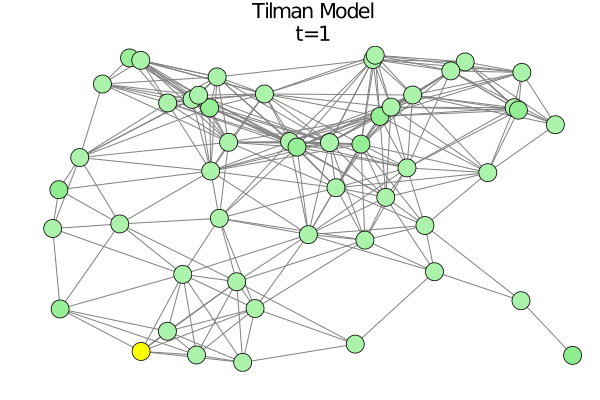

In [8]:
#generate random geometric graph
coordinates,adjacency=create_rgg(β,γ)

#get simulation result
timeline,status_agents1,status_agents2,status_habitats=tilman_model(adjacency,params)

#cleanse data
timeline,status_agents1,status_agents2,status_habitats=cleanse_matrix(timeline,
    status_agents1,status_agents2,status_habitats)

#viz
viz(timeline,status_habitats,adjacency,
    coordinates,"Tilman Model","tilman model1.gif")

In the figure above, color green denotes the habitats are predominantly occupied by native species, color white denotes the habitats are in a balanced mix and color yellow denotes the habitats are predominantly occupied by the invasive species. In no time, habitats are controlled by introduced species. The expansion in a complex network follows the rule of nearest neighbors. The indigenous species have to retreat back to their preoccupied habitats. Apparently, the occupancy rate of habitats depends on three things, the emigration rate of the intruders, the shortest distance from the base camp of the intruders and the connectivity of the habitats. The bottom right vertex in the figure above is a perfect demonstration.

&nbsp;
# With Tolerance
&nbsp;

Let's slightly modify the model. The tolerance is brought to the aboriginal. The natives are willing to migrate to habitats predominantly occupied by the invasive species. The co-existence of two species should be improved.

&nbsp;
### Natural growth rate difference
&nbsp;

The first case still creates heterogenous conditions. Two species have different natural growth rate. Invasive species have slightly higher crude birth rate. So the habitat competition turns out to be the combat of wombs.

&nbsp;

In [9]:
#crude birth rate
α1=0.008;α2=0.01

#crude death rate
δ1=0.005;δ2=0.005

#emigration rate
ϵ1=0.4;ϵ2=0.4

#maximum elapsed time
tmax=25

#beginning time
t=0

#initial population
ρ1=500;ρ2=500

#number of habitats
β=50

#radius threshold
γ=0.3

#occupancy rate of the natives
ω=0.2

#packing
params=(t,tmax,α1,α1,β,δ1,δ2,ϵ1,ϵ2,ρ1,ρ2,ω)

(0, 25, 0.008, 0.008, 50, 0.005, 0.005, 0.4, 0.4, 500, 500, 0.2)

┌ Info: Saved animation to 
│   fn = h:\tilman model2.gif
└ @ Plots C:\Users\T.M.\.julia\packages\Plots\Xnzc7\src\animation.jl:104


Plots.AnimatedGif("h:\\tilman model2.gif")
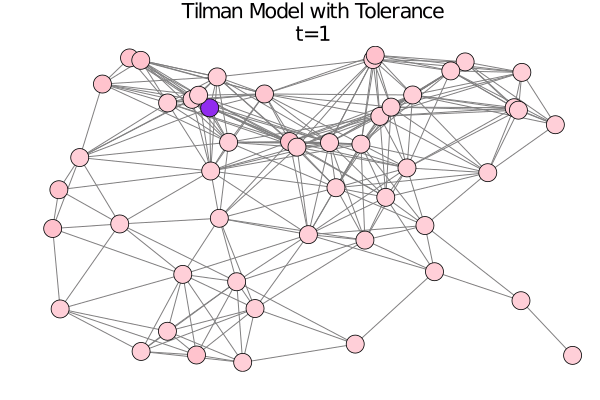

In [10]:
#get simulation result
timeline,status_agents1,status_agents2,status_habitats=tilman_model(adjacency,params,false)

#cleanse data
timeline,status_agents1,status_agents2,status_habitats=cleanse_matrix(timeline,
    status_agents1,status_agents2,status_habitats)

#viz
viz(timeline,status_habitats,adjacency,
    coordinates,"Tilman Model with Tolerance","tilman model2.gif",
    cgrad([:purple2,:white,:pink]))

In the figure above, color pink denotes the habitats are predominantly occupied by native species, color white denotes the habitats are in a balanced mix and color purple denotes the habitats are predominantly occupied by the invasive species. Even a tiny difference in natural growth rate can lead to habitat occupancy disparity. Unlike the previous Tilman Model, the introduced species has a slower start. The occupancy rate of the intruders follows exponential curve.

&nbsp;
### Homogenous Conditions
&nbsp;

Now let's level the playing field. Invasive species doesn't have an edge of explosive population growth. Native species still enters the game before the intruders.

&nbsp;

In [11]:
#crude birth rate
α1=0.0;α2=0.0

#crude death rate
δ1=0.0;δ2=0.0

#emigration rate
ϵ1=0.5;ϵ2=0.5

#maximum elapsed time
tmax=25

#beginning time
t=0

#initial population
ρ1=500;ρ2=500

#number of habitats
β=50

#radius threshold
γ=0.3

#occupancy rate of the natives
ω=0.2

#packing
params=(t,tmax,α1,α1,β,δ1,δ2,ϵ1,ϵ2,ρ1,ρ2,ω)

(0, 25, 0.0, 0.0, 50, 0.0, 0.0, 0.5, 0.5, 500, 500, 0.2)

┌ Info: Saved animation to 
│   fn = h:\tilman model3.gif
└ @ Plots C:\Users\T.M.\.julia\packages\Plots\Xnzc7\src\animation.jl:104


Plots.AnimatedGif("h:\\tilman model3.gif")
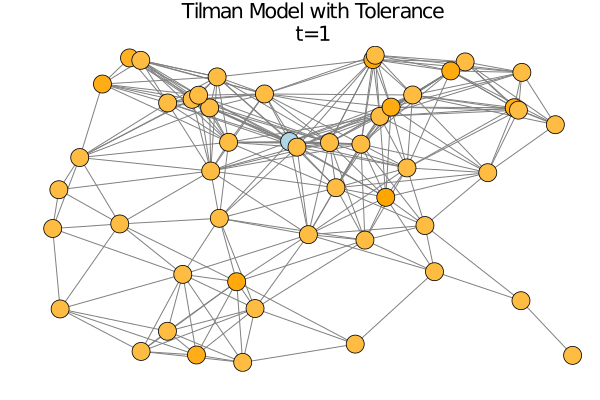

In [12]:
#get simulation result
timeline,status_agents1,status_agents2,status_habitats=tilman_model(adjacency,params,false)

#cleanse data
timeline,status_agents1,status_agents2,status_habitats=cleanse_matrix(timeline,
    status_agents1,status_agents2,status_habitats)

#viz
viz(timeline,status_habitats,adjacency,
    coordinates,"Tilman Model with Tolerance","tilman model3.gif",
    cgrad([:lightblue,:white,:orange]))

In the figure above, color orange denotes the habitats are predominantly occupied by native species, color white denotes the habitats are in a balanced mix and color blue denotes the habitats are predominantly occupied by the invasive species. More harmonic co-existence has emerged, even though the advantage of pre-occupancy exists. The reserved areas of the indigenous have barely been invaded. Furthermore, another interesting phenomenon reveals itself. It seems that species segregation is the new normal. To investigate the segregation, we bring a new model from sociology.

&nbsp;
# Schelling's Model of Racial Segregation
&nbsp;

Schelling's model is named after the Nobel laureate Thomas Schelling. It was published in 1971 long before today's "I can't breathe" movement. It is rather simple agent-based model implemented on a square lattice. It implies that a racial segregation society can be easily created by a mild intolerance towards another race. Each agent has a happiness threshold. Only when sufficient amount of the neighbors has the same ethnicity as the agent, the agent reaches the state of satisfaction. The agent will move to empty houses if unhappy.

In the original paper, there are two ethnicities. Nonetheless, the world isn't in black and white. All lives matter. In this example, we simulate three common ethnicities in UK, Asians (both East Asians and South Asians), Blacks (both Africans and Caribbeans) and Whites (including Arabs). Moreover, agents are allowed to move to any empty house in the origin model. We need to change this part into the rule of the nearest neighbor. Our model will be implemented on a random geometric graph instead of a square lattice.

Let's create our own version of Seine-Saint-Denis!

&nbsp;

In [13]:
#using gillespie algorithm to simulate agent based schelling s model
function schelling_s_model(adjacency,params)ssssssssssssss
    
    #unpack
    t,tmax,num_of_habitats,num_of_races,pct_of_empty,happiness_threshold=params
    
    #compute number of occupants per ethnicity
    num_of_occupants_per_race=Int32(fld(num_of_habitats*(1-pct_of_empty),num_of_races))
    
    #randomly assign occupants into habitats
    habitats=[]
    
    for i in 1:num_of_races
        
        append!(habitats,[i for _ in 1:num_of_occupants_per_race])
        
    end
    
    append!(habitats,[0 for _ in 1:(num_of_habitats-length(habitats))])
        
    shuffle!(habitats)
    
   
    #keep track of population inside habitats
    status_habitats=Any[]
    push!(status_habitats,deepcopy(habitats))    
          
    #create timeline
    timeline=Float32[t]
    
    #no need for tau leaping
    #at each iteration,all unhappy residents move around to find empty houses            
    while t<tmax
            
        habitats=deepcopy(status_habitats[end])
        
        #find occupied habitats and shuffle them before checking happiness
        occupied=[i for i in 1:num_of_habitats if habitats[i]!=0]                    
        shuffle!(occupied)
                    
        for i in occupied
            
            #check neighbors with similar ethnicity
            migration=[ii for ii in 1:length(adjacency) if adjacency[i][ii]!=0]
            neighbors=habitats[migration]            
            
            num_of_similar=length([iii for iii in neighbors if iii==habitats[i]])
            
            #if unhappy, the agent will find empty habitat nearby
            if num_of_similar/length(migration)<happiness_threshold
                                            
                empty_habitats=[migration[j] for j in 1:length(migration) if neighbors[j]==0]
                
                #if no empty habitat nearby, the agent will be stuck
                if length(empty_habitats)>0

                    habitats[rand(empty_habitats)]=deepcopy(habitats[i])                   
                    habitats[i]=0
                    
                end
                                                                    
            end
                                                                
        end
            
        
        #keep track of habitat change                            
        push!(status_habitats,deepcopy(habitats))
        
        #update timeline
        t+=1
        push!(timeline,t)

    end
    
    return timeline,status_habitats
                                
end

schelling_s_model (generic function with 1 method)

In [14]:
#maximum elapsed time
tmax=25

#beginning time
t=0

#number of habitats
β=100

#radius threshold
γ=0.2

#number of ethnicities
#here we use asian,black,white
ϕ=3

#minimum percentage of empty habitats
χ=0.3

#similarity of neighbors to reach happiness
ψ=0.3

#packing
params=(t,tmax,β,ϕ,χ,ψ)

(0, 25, 100, 3, 0.3, 0.3)

┌ Info: Saved animation to 
│   fn = h:\schelling's model.gif
└ @ Plots C:\Users\T.M.\.julia\packages\Plots\Xnzc7\src\animation.jl:104


Plots.AnimatedGif("h:\\schelling's model.gif")
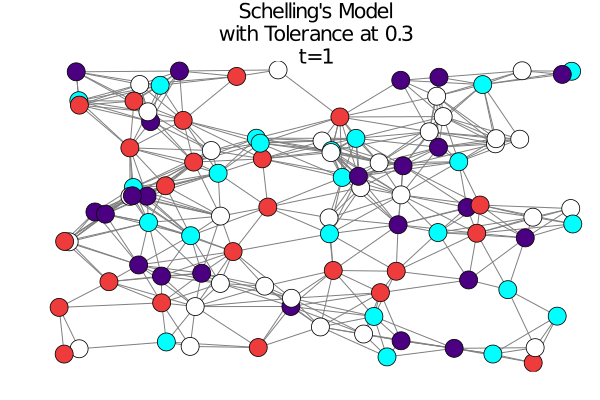

In [15]:
#generate random geometric graph
coordinates,adjacency=create_rgg(β,γ)

#get simulation result
timeline,status_habitats=schelling_s_model(adjacency,params)

#viz
viz(timeline,status_habitats,adjacency,
    coordinates,"Schelling's Model\nwith Tolerance at $ψ","schelling's model.gif",
    cgrad([:white,:cyan,:indigo,:brown2]))

In the figure above, color white denotes empty habitats where agents can move in, color violet denotes Asians, color red denotes Blacks and color azure denotes Whites. Different from a traditional Schelling's model, people can only move to the nearest neighbor at each iteration. The movement of people are constrained by the spatial structure.

Since the happiness threshold is a relative percentage than an absolute number, a low threshold guarantees a more stable status. It is intuitive that higher vertex degree requires more neighbors of the same ethnicity which creates more unhappy agents. A low happiness threshold (more open to diversity) creates a healthy society with less movement. Additionally, a maximal clique of the same ethnicity (e.g. bottom left red triangle) is a very stable structure. Maximal cliques form most of the racial segregations in the steady state.

Compared to square lattice, random geometric graph seems to be a less segregated but more volatile society. As counterintuitive as it sounds, the best way to encourage integration is probably physical barrier? If each vertex (house) has a very small degree, wouldn’t we eliminate Danish ghetto/no-go zone in Stockholm/Parisien ZUS?

###### If you need a recap of maximal clique, you can check out the following link.

https://github.com/je-suis-tm/graph-theory/blob/master/maximal%20clique.ipynb

&nbsp;
### Further Reading
&nbsp;

1. Schelling TC (1971)

	Dynamic Models Of Segregation
    
    https://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf

	*The original paper of Schelling's Model*

&nbsp;
2. Tilman D (1994)

	Competition And Biodiversity In Spatially Structured Habitats
    
    https://users.wfu.edu/silmanmr/bio377/assignments/Readings/tilman1994.pdf

	*The original paper of Tilman Model*